In [ ]:
!pip install datasets
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch.nn as nn
from torchmetrics import JaccardIndex, F1Score
from tqdm import tqdm
import torch.optim as optim

In [ ]:
train_dataset = load_dataset("1aurent/ADE20K", split="train")
val_dataset = load_dataset("1aurent/ADE20K", split="validation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.77k [00:00<?, ?B/s]

train-00000-of-00010.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

train-00001-of-00010.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00002-of-00010.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

train-00003-of-00010.parquet:   0%|          | 0.00/293M [00:00<?, ?B/s]

train-00004-of-00010.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

train-00005-of-00010.parquet:   0%|          | 0.00/679M [00:00<?, ?B/s]

train-00006-of-00010.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

train-00007-of-00010.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00008-of-00010.parquet:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

train-00009-of-00010.parquet:   0%|          | 0.00/555M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25574 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def display_image_and_masks(image, segmentation_mask,):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(segmentation_mask)
    axes[1].set_title("Semantic Segmentation Mask")
    axes[1].axis("off")

In [ ]:
def filter_by_objects_batch(batch, target_objects):

    filtered_indices = []
    for i, objects in enumerate(batch["objects"]):
        object_names = [obj['name'] for obj in objects]
        if any(target in object_names for target in target_objects):
            filtered_indices.append(i)
    return {"keep": [i in filtered_indices for i in range(len(batch["objects"]))]}

target_objects = ["chair", "person"]

filtered_train_dataset = train_dataset.filter(
    lambda batch: filter_by_objects_batch(batch, target_objects)["keep"],
    batched=True,
    batch_size=100,
)

filtered_val_dataset = val_dataset.filter(
    lambda batch: filter_by_objects_batch(batch, target_objects)["keep"],
    batched=True,
    batch_size=100,
)

print(f"Filtered Train Dataset Size: {len(filtered_train_dataset)}")
print(f"Filtered Validation Dataset Size: {len(filtered_val_dataset)}")

Filter:   0%|          | 0/25574 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filtered Train Dataset Size: 3940
Filtered Validation Dataset Size: 320


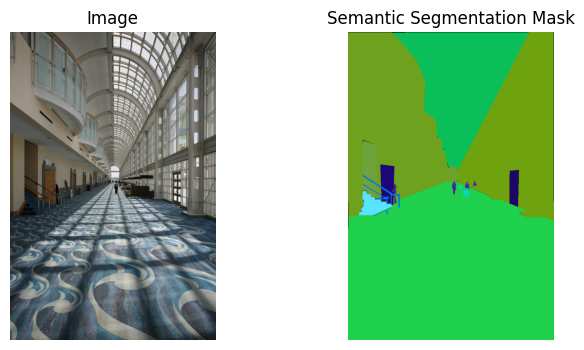

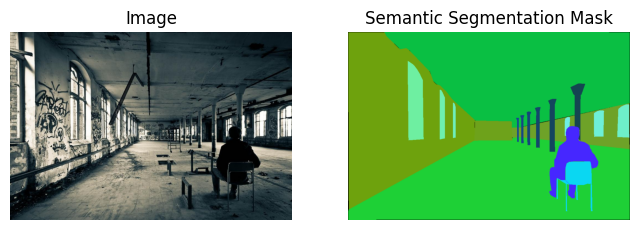

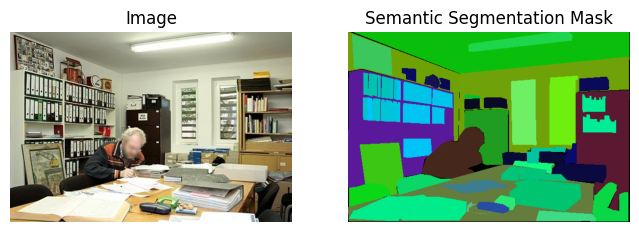

In [ ]:
for idx in range(3):
    data = filtered_train_dataset[idx]
    image = data['image']
    segmentation_mask = data['segmentations'][0]
    display_image_and_masks(image, segmentation_mask)

In [ ]:
class ADE20KDataset(Dataset):
  def __init__(self, dataset, class_labels, image_size):
    self.dataset = dataset
    self.class_labels = class_labels
    self.image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    self.mask_transform = transforms.Compose([
        transforms.Resize(image_size, interpolation=transforms.InterpolationMode.NEAREST)
    ])

  def __len__(self):
    return len(self.dataset)


  def generate_mask(self, data_point, class_labels):
    width, height = data_point['image'].size
    mask = Image.new('L', (width, height), 0)

    draw = ImageDraw.Draw(mask)

    for obj in data_point['objects']:
        object_name = obj['name'].lower()
        for key in class_labels:
            if key in object_name:
                polygon = list(zip(obj['polygon']['x'], obj['polygon']['y']))
                class_id = class_labels[key]
                draw.polygon(polygon, fill=class_id)
                break

    mask = np.array(mask)

    return mask

  def __getitem__(self, idx):
    data_point = self.dataset[idx]


    image = self.image_transform(data_point['image'])

    # Generate and transform the mask
    mask = self.generate_mask(data_point, self.class_labels)
    mask = self.mask_transform(Image.fromarray(mask))
    mask = torch.tensor(np.array(mask), dtype=torch.long)


    return image, mask


In [ ]:
class_label = {
      "person": 1,
      "chair": 2
  }

train_ds = ADE20KDataset(filtered_train_dataset, class_label, (256, 256))
val_ds = ADE20KDataset(filtered_val_dataset, class_label, (256, 256))

train_dsloader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dsloader = DataLoader(val_ds, batch_size=32, shuffle=True)


train_dsloader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dsloader = DataLoader(val_ds, batch_size=32, shuffle=True)

for images, masks in val_dsloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break

Image batch shape: torch.Size([32, 3, 256, 256])
Mask batch shape: torch.Size([32, 256, 256])


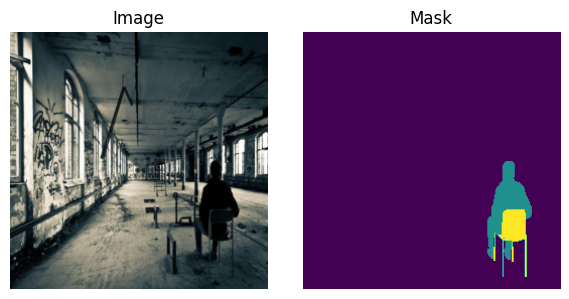

In [ ]:
image, mask= train_ds[1]

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = image.permute(1, 2, 0).numpy()
image_np = (image_np * std + mean)
image_np = np.clip(image_np, 0, 1)

mask_np = mask.numpy()

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(image_np)
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(mask_np, cmap="viridis")
ax[1].set_title("Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = 3
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")
image_processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    do_reduce_labels=True
)

model.decode_head.classifier = nn.Conv2d(768, num_classes, kernel_size=(1, 1))
model.config.num_labels = num_classes

model.to(device)

cuda


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
iou_metric = JaccardIndex(num_classes=num_classes, task='multiclass').to(device)
f1_metric = F1Score(num_classes=num_classes, task='multiclass').to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)


from torchvision.transforms.functional import resize

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()


        outputs = model(images).logits
        _, _, h, w = outputs.shape


        masks_resized = resize(masks, size=(h, w), interpolation=transforms.InterpolationMode.NEAREST)
        masks_resized = masks_resized.long()

        loss = loss_fn(outputs, masks_resized)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    iou_metric.reset()
    f1_metric.reset()
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images).logits
            _, _, h, w = outputs.shape

            # Resize masks to match output dimensions
            masks_resized = resize(masks, size=(h, w), interpolation=transforms.InterpolationMode.NEAREST)
            masks_resized = masks_resized.long()

            # Compute loss
            loss = loss_fn(outputs, masks_resized)
            running_loss += loss.item() * images.size(0)

            # Compute metrics
            preds = torch.argmax(outputs, dim=1)
            iou_metric.update(preds, masks_resized)
            f1_metric.update(preds, masks_resized)

    epoch_loss = running_loss / len(dataloader.dataset)
    mean_iou = iou_metric.compute().item()
    f1_score = f1_metric.compute().item()
    return epoch_loss, mean_iou, f1_score



In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_dsloader, optimizer, criterion, device)
    val_loss, mean_iou, f1_score = validate(model, val_dsloader, criterion, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Mean IoU: {mean_iou:.4f} | F1 Score: {f1_score:.4f}")

Epoch 1/10


Training:   0%|          | 0/124 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Validation: 100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


Train Loss: 0.6388 | Val Loss: 0.2879 | Mean IoU: 0.6248 | F1 Score: 0.9412
Epoch 2/10


Validation: 100%|██████████| 10/10 [01:27<00:00,  8.71s/it]


Train Loss: 0.2483 | Val Loss: 0.1928 | Mean IoU: 0.6663 | F1 Score: 0.9478
Epoch 3/10


Validation: 100%|██████████| 10/10 [01:27<00:00,  8.74s/it]


Train Loss: 0.1747 | Val Loss: 0.1576 | Mean IoU: 0.6749 | F1 Score: 0.9511
Epoch 4/10


Validation: 100%|██████████| 10/10 [01:27<00:00,  8.76s/it]


Train Loss: 0.1425 | Val Loss: 0.1405 | Mean IoU: 0.6984 | F1 Score: 0.9530
Epoch 5/10


Validation: 100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


Train Loss: 0.1221 | Val Loss: 0.1304 | Mean IoU: 0.6888 | F1 Score: 0.9539
Epoch 6/10


Validation: 100%|██████████| 10/10 [01:24<00:00,  8.48s/it]


Train Loss: 0.1093 | Val Loss: 0.1294 | Mean IoU: 0.6908 | F1 Score: 0.9547
Epoch 7/10


Validation: 100%|██████████| 10/10 [01:24<00:00,  8.45s/it]


Train Loss: 0.1010 | Val Loss: 0.1167 | Mean IoU: 0.7184 | F1 Score: 0.9570
Epoch 8/10


Validation: 100%|██████████| 10/10 [01:24<00:00,  8.41s/it]


Train Loss: 0.0928 | Val Loss: 0.1163 | Mean IoU: 0.7243 | F1 Score: 0.9567
Epoch 9/10


Validation: 100%|██████████| 10/10 [01:25<00:00,  8.56s/it]


Train Loss: 0.0865 | Val Loss: 0.1140 | Mean IoU: 0.7245 | F1 Score: 0.9580
Epoch 10/10


Validation: 100%|██████████| 10/10 [01:25<00:00,  8.59s/it]

Train Loss: 0.0822 | Val Loss: 0.1169 | Mean IoU: 0.7182 | F1 Score: 0.9588


In [ ]:
save_path = "b2_finetuned.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_epochs': num_epochs,
    'final_train_loss': train_loss,
    'final_val_loss': val_loss,
    'final_mean_iou': mean_iou,
    'final_f1_score': f1_score,
}, save_path)

<ipython-input-26-8ba2c136779c>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("b2_finetuned.pth", map_location=torch.device('cuda' if torch.cuda.

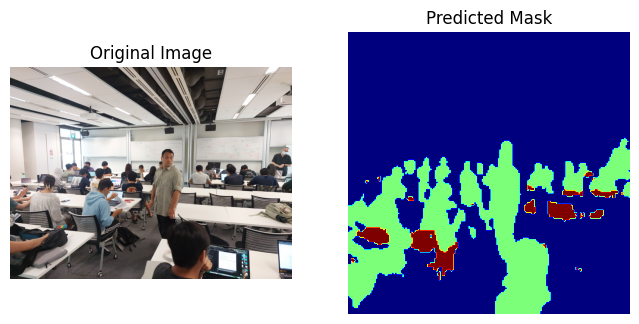

Class person: 10 instances
Class chair: 10 instances
------------------------------


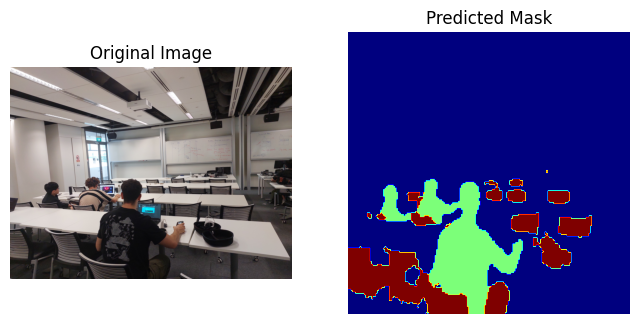

Class person: 2 instances
Class chair: 13 instances
------------------------------


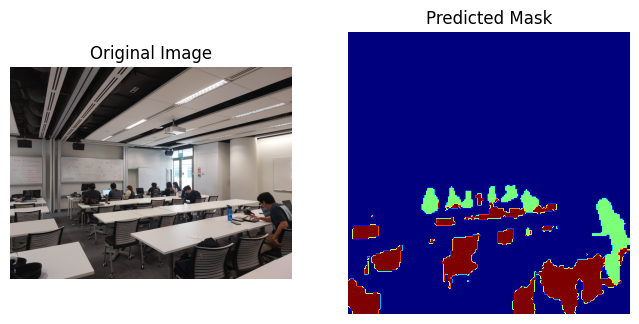

Class person: 7 instances
Class chair: 14 instances
------------------------------


In [ ]:
import os
from scipy.ndimage import label
from skimage.morphology import remove_small_objects

class_label = {
      "person": 1,
      "chair": 2
  }

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")

num_classes = 3
model.decode_head.classifier = torch.nn.Conv2d(768, num_classes, kernel_size=(1, 1))
model.config.num_labels = num_classes
checkpoint = torch.load("b2_finetuned.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image_size = (768, 768)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


image_folder = "/content/test_samples"
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue


    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_tensor).logits
        predictions = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

        class_instance_counts = {}
        for label_name, class_id in class_label.items():
          class_mask = (predictions == class_id)  # Binary mask for the class
          class_mask = remove_small_objects(class_mask, min_size=10)  # Remove small artifacts
          labeled_mask, num_instances = label(class_mask)  # Label connected components
          class_instance_counts[label_name] = num_instances


    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predictions, cmap="jet")
    plt.axis("off")

    plt.show()

    for class_id, count in class_instance_counts.items():
        print(f"Class {class_id}: {count} instances")
    print("-" * 30)